# TP 2 : RL

**Il est interdit d'utiliser la fonction 'compile' de TensorFlow pour ce TP**

Source utile : https://arxiv.org/pdf/1312.5602.pdf

Le but de ce TP sera de découvrir et mettre en place un algorithme d'apprentissage par renforcement profond : le DQN.
Vous apprendrez à un agent à jouer au jeu du cartpole, qui consiste à déplacer une plateforme sur laquelle est posé un baton de manière à ce que le baton reste en équilibre sur la plateforme.

Nous allons utiliser la librairie TensorFlow et faire tourner notre code sous Google Colab pour nos TP, ce qui aura l'avantage de nous permettre d'utiliser les GPUs mis à disposition gratuitement par Google.
Vous êtes libre d'utiliser une autre librairie que TensorFlow si vous en maîtrisez une autre ou votre machine personnelle si celle-ci possède un GPU suffisant, mais il est probable que les phases d'entraînement soit plus rapides sous Colab.

N'hésitez pas à vous référer aux docs de TensorFlow 2 et Keras disponibles sur internet lors de ce TP.

Ce TP s'effectue individuellement ou en binome. Veuillez respecter les consignes suivantes pour le rendu de votre travail :

*   Renommez le selon le format suivant : "DL_2023_TP_RL_prenom1_nom1_prenom2_nom2.ipynb".
*   Veillez à ce que votre nom et prénom soient complétés dans la cellule ci-dessous.
*   Veillez à avoir bien exécuté toutes les cellules de code et que les résultats soient tous bien visible dans le notebook sans nécessiter une ré-exécution.
*   Partagez le notebook avec ranvier.thomas.pro@gmail.com.

Si vous avez effectué le TP autrement que sur Google Colab :

*   Renommez le selon le format suivant : "DL_2023_TP_RL_prenom1_nom1_prenom2_nom2.ipynb".
*   Téléchargez le fichier ipynb.
*   Envoyez le fichier en pièce-jointe à ranvier.thomas.pro@gmail.com, en indiquant en tant qu'objet : "TP RL prenom1 nom1 prenom2 nom2".

---

## Veuillez compléter vos noms et prénoms ci-dessous :

*   **Prenom 1** : Aicha
*   **Nom 1** : EL BOU


In [ ]:
%%capture
import tensorflow as tf
import gym
from gym.wrappers.record_video import RecordVideo
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from IPython.display import HTML
from base64 import b64encode
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

---
# Visualisation d'un épisode de Cartpole

Vous allez utiliser l'environement cartpole proposé par la librairie gym. A chaque étape l'environement nous envoie une observation correspondant à l'état actuel de l'environement et on doit envoyer une action (0 ou 1 pour gauche ou droite) en réponse.

Commencez par visualiser un épisode en ne sélectionnant que des actions aléatoires.

In [ ]:
# Environment initialization
env = gym.make('CartPole-v1')
# Put the environment in a wrapper to save the episode video
env = RecordVideo(env, './example')

# Start a new episode and get the first environment state
state = env.reset()
done = False
# While the episode is not over
while not done:
    # Select a random action
    action_index = random.randrange(env.action_space.n)
    # Execute selected action in the environment and get new observation and reward
    next_state, reward, done, _ = env.step(action_index)

env.close()

In [ ]:
def viz_episode(filename):
    mp4 = open('./example/' + filename,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

    return HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

# Play the episode video
viz_episode('rl-video-episode-0.mp4')

---
# Déclaration des hyperparamètres

Le but de ce TP n'étant pas de chercher les meilleurs hyperparamètres possibles vous trouverez ci-dessous l'initilisation d'hyperparamètres par défaut qui donnent de bons résultats.

In [ ]:
# Reinitialize environment
env = gym.make('CartPole-v1')

# Get environment observation size and number of possible actions
obs_size = env.observation_space.shape[0]
nb_actions = env.action_space.n

#Hyper Parameters
training_episodes = 200                     # Max number of training episodes
gamma = .95                                 # Discount factor used in Q-function
learning_rate = .001                        # Learning rate of the optimizer
batch_size = 24
epsilon_max = 1.                            # Maximum epsilon value at 1.
epsilon_min = .05                           # Minimum epsilon value at .05
epsilon_decay = .995                        # Epsilon decay factor at .995
replay_memory_capacity = 2500               # Limit memory capacity at 2500
print_step = 10                             # Print recap every 10 steps
target_avg_reward = 200                     # Early stop if avg reward >= 200

---
# Création de la replay memory

La replay memory est utilisée pour stocker les transitions entre l'agent et l'environement. Chaque transition stockée est composée de l'état de départ, l'action réalisée par l'agent, l'état d'arrivée, le reward obtenu et si l'état d'arrivée est terminal ou non.

In [ ]:
class ReplayMemory:
    def __init__(self, capacity):
        self._capacity = capacity
        self._memory = []
        self._position = 0

    def push(self, state, next_state, action, reward, done):
        transition = (state, next_state, action, reward, done)
        if len(self._memory) < self._capacity:
            self._memory.append(transition)
        else:
            self._memory[self._position] = transition
        self._position = (self._position + 1) % self._capacity

    def sample(self, batch_size):
        samples = random.sample(self._memory, batch_size)
        state_s, state_next_s, action_s, rewards_s, opp_done_s = zip(*samples)

        return np.array(state_s), np.array(state_next_s), tf.convert_to_tensor(action_s), tf.convert_to_tensor(rewards_s, dtype=tf.float32), 1.0 - tf.convert_to_tensor(opp_done_s, dtype=tf.float32)

    def __len__(self):
        return len(self._memory)


---
# Création de l'agent

L'agent apprend à intéragir et executer ses actions avec l'environnement.

In [ ]:
class Agent():
    def __init__(self, replay_memory, model, optimizer, loss_function, env):
        self._rm = replay_memory
        self._epsilon = epsilon_max
        self._model = model
        self._optimizer = optimizer
        self._loss_function = loss_function
        self._env = env
        self._reward_hist = []

    def train(self):
        """
        Méthode principale, lance l'entraînement de l'agent.
        """
        start = time.time()
        avg_reward = 0
        for episode in range(training_episodes):
            # Run 1 episode
            episode_reward = self._run_episode()
            self._reward_hist.append(episode_reward)
            avg_reward += episode_reward
            if (episode + 1) % print_step == 0:
                print(f'episode: {episode + 1}/{training_episodes}, avg reward: {avg_reward / print_step}, e: {self._epsilon}')
                # Early stop
                if avg_reward / print_step >= target_avg_reward:
                    break
                avg_reward = 0
        print(f'training done in {time.time() - start:.2f}s')
        self._plot_history()

    def _run_episode(self):
        """
        Cette méthode doit executer un épisode d'apprentissage.
        """
        state = np.array(self._env.reset(), dtype=np.float32)

        episode_reward = 0
        done = False
        while not done:
            # Select an action
            action_index = self._select_action(state)


            next_state, reward, done, _ = self._env.step(action_index)

            next_state = np.array(next_state, dtype=np.float32)

            episode_reward += reward

            action_one_hot = tf.one_hot(action_index, nb_actions)

            self._rm.push(state, next_state, action_one_hot, reward, done)

            state = next_state

            if len(self._rm) >= batch_size:
                state_s, state_next_s, action_s, rewards_s, opp_done_s = self._rm.sample(batch_size)
                self._optimize(state_s, state_next_s, action_s, rewards_s, opp_done_s)

        return episode_reward

    def _select_action(self, state):
        """
        Select an action using epsilon-greedy policy.
        """
        if np.random.rand() < self._epsilon:
            return np.random.choice(nb_actions)
        else:
            q_values = self._model(np.expand_dims(state, axis=0)).numpy()
            return np.argmax(q_values)

    @tf.function
    def _optimize(self, state_s, state_next_s, action_s, rewards_s, opp_done_s):
        """
        Cette méthode calcule la Q-loss, elle doit ensuite faire la
        backpropagation.
        """
        q_values_target = self._model(state_next_s)
        q_values_target = rewards_s + (gamma * tf.reduce_max(q_values_target, axis=1)) * opp_done_s
        with tf.GradientTape() as tape:
            q_values_pred = self._model(state_s)
            q_values_pred = tf.reduce_sum(tf.multiply(q_values_pred, action_s), axis=1)
            loss = self._loss_function(q_values_target, q_values_pred)
        gradients = tape.gradient(loss, self._model.trainable_variables)
        self._optimizer.apply_gradients(zip(gradients, self._model.trainable_variables))

        self._epsilon = max(epsilon_min, self._epsilon * epsilon_decay)


    def _plot_history(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self._reward_hist)
        plt.xlabel('episodes')
        plt.ylabel('reward')
        plt.title('Reward per episode')
        plt.show()

    def real_episode(self, env):
        state = env.reset()
        done = False
        while not done:
            output = self._model(np.expand_dims(state, axis=0))
            action_index = np.argmax(output.numpy())
            state, _, done, _ = env.step(action_index)


---
# Entraînement de l'agent

Si tout est correct vous devriez voir la récompense moyenne des 10 derniers épisodes d'apprentissage commencer à augmenter entre 50 et 100 épisodes.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Define a fully-connected model
model = Sequential([
    Dense(24, activation='relu', input_shape=(obs_size,)),
    Dense(24, activation='relu'),
    Dense(nb_actions, activation='linear')
])

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Loss function
loss_function = tf.keras.losses.MeanSquaredError()

replay_memory = ReplayMemory(replay_memory_capacity)

# Create the agent
agent = Agent(replay_memory, model, optimizer, loss_function, env)


episode: 10/200, avg reward: 24.1, e: 0.990025
episode: 20/200, avg reward: 24.6, e: 0.990025
episode: 30/200, avg reward: 15.2, e: 0.990025
episode: 40/200, avg reward: 19.8, e: 0.990025
episode: 50/200, avg reward: 20.1, e: 0.990025
episode: 60/200, avg reward: 17.2, e: 0.990025
episode: 70/200, avg reward: 18.9, e: 0.990025
episode: 80/200, avg reward: 20.5, e: 0.990025
episode: 90/200, avg reward: 24.8, e: 0.990025
episode: 100/200, avg reward: 29.4, e: 0.990025
episode: 110/200, avg reward: 21.7, e: 0.990025
episode: 120/200, avg reward: 28.6, e: 0.990025
episode: 130/200, avg reward: 24.2, e: 0.990025
episode: 140/200, avg reward: 19.6, e: 0.990025
episode: 150/200, avg reward: 19.9, e: 0.990025
episode: 160/200, avg reward: 28.7, e: 0.990025
episode: 170/200, avg reward: 30.7, e: 0.990025
episode: 180/200, avg reward: 17.6, e: 0.990025
episode: 190/200, avg reward: 20.4, e: 0.990025
episode: 200/200, avg reward: 23.6, e: 0.990025
training done in 23.36s


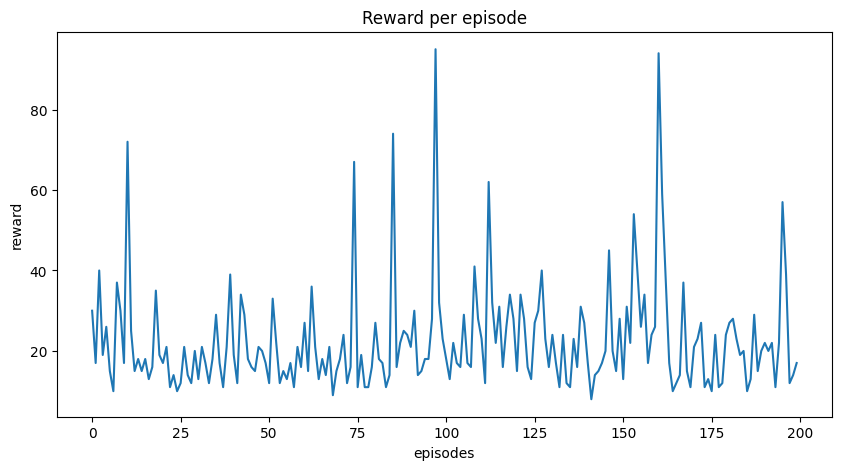

In [ ]:
# Training
agent.train()

In [ ]:
# Run a test episode
env = gym.make('CartPole-v1')
env = RecordVideo(env, './episode')
agent.real_episode(env)
env.close()

In [ ]:
# Visualize the test episode
viz_episode('rl-video-episode-0.mp4')
